# GDR RSD School - Hackathon

## Prerequisites

- Configure python virtual environment: python3 -m venv hackathon
- Activate virtual environment: source hackathon/bin/activate
- Install Jupyter-lab: pip install jupyterlab 
- Install EnOSlib: pip install enoslib
- Setting up IoT-LAB credentials (.iotlabrc): iotlab-auth -u <username>
- OML plot tools (iot-lab): pip install oml_plot_tools

Link: https://discovery.gitlabpages.inria.fr/enoslib/tutorials/iotlab.html

## Introduction

Explain the what is gonna be done, nothing now...

## Initialization

Let's start by loading the libraries used in our test.

In [1]:
from enoslib import *

import logging
import sys

Note: Openstack clients not installed


Configuring logging: save DEBUG to a file and INFO to stdout

In [2]:
log = logging.getLogger()
log.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fileHandler = logging.FileHandler("debug.log", 'a')
fileHandler.setLevel(logging.DEBUG)
fileHandler.setFormatter(formatter)
log.addHandler(fileHandler)

cformat = logging.Formatter("[%(levelname)8s] : %(message)s")
consoleHandler = logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(cformat)
consoleHandler.setLevel(logging.INFO)
log.addHandler(consoleHandler)

## RPL + CoAP + ContikiMAC

### Reserving IoT-LAB resources

**Describing the resources** used in IoT-LAB.

In [7]:
iotlab_dict = {
    "job_name": "hackathon",
    "walltime": "03:00",       # duration of the experiment: e.g. 1 hour
    "resources":
    {"machines": [
        {
            "roles": ["coap-server"],      # user-defined role for these nodes: CoAP servers
            "archi": "m3:at86rf231",       # architecture of the nodes: M3
            "site": "strasbourg",
            "number": 3,
            "image": "firmware/contikimac/er-example-server.iotlab-m3",     # initial image to be installed on the nodes
            "profile": "energy",           # monitoring profile, defined below
        },
        {
            "roles": ["border-router"],   # user-defined string, 1 border-router in our example
            "archi": "m3:at86rf231",
            "site": "strasbourg",
            "number": 1,
            "image": "firmware/contikimac/border-router.iotlab-m3",
            "profile": "energy",
        },
    ]},
    "monitoring": {
        "profiles": [{
            "name": "energy",           # More details: https://www.iot-lab.info/legacy/tutorials/monitoring-consumption-m3/index.html
            "archi": "m3",
            "consumption": {
                "current": True,
                "power": True,
                "voltage": True,
                "period": 8244,         # interval between measurements in us
                "average": 4,
            },
        }]
    }
}

# creating the object for our reservation
# the nodes aren't avaible until you call init() on these objects
iotlab_conf = IotlabConf.from_dictionary(iotlab_dict)
iotlab_provider = Iotlab(iotlab_conf)

Actually **reserving** the nodes in the testbed.

In [8]:
iotlab_roles, iotlab_networks = iotlab_provider.init()

[    INFO] : Submitting profile: energy, got {'nodearch': 'm3', 'power': 'dc', 'consumption': {'period': 8244, 'average': 4, 'current': True, 'voltage': True, 'power': True}, 'profilename': 'energy'}
[    INFO] : Submitting FIT/IoT-LAB: job id: hackathon, duration: 03:00, resources: [{'type': 'alias', 'nodes': AliasNodes(3, 'strasbourg', 'm3:at86rf231', False, _alias='1'), 'firmware': None, 'profile': 'energy', 'associations': {}}, {'type': 'alias', 'nodes': AliasNodes(1, 'strasbourg', 'm3:at86rf231', False, _alias='2'), 'firmware': None, 'profile': 'energy', 'associations': {}}]
[    INFO] : Job submitted: 271937
[    INFO] : Waiting for job id (271937) to be in running state
[    INFO] : Job id (271937) is running
[    INFO] : Finished reserving nodes: hosts [], sensors [<IotlabSensor(roles=['coap-server'], address=m3-12.strasbourg.iot-lab.info, site=strasbourg, uid=9588)>image=firmware/contikimac/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-13.stras

### IoT-LAB setup

**Bridging M3 wireless network to internet**.
Based on the tutorial: https://www.iot-lab.info/legacy/tutorials/contiki-coap-m3/index.html

Run the tunslip6 in the frontend node. This daemon will connect your border router with the outside world.

Each group need to select a different network for communication
More details in: https://www.iot-lab.info/legacy/tutorials/understand-ipv6-subnetting-on-the-fit-iot-lab-testbed/index.html

In [9]:
my_id = "f0b0"   # 32 subnets available in the range f0a0 to f0bf
iotlab_ipv6_net="2001:660:4701:%s::" % (my_id)

import iotlabcli.auth
iotlab_user, _ = iotlabcli.auth.get_user_credentials()   # get your credentials from .iotlabrc to connect to frontend node.

# provider to access the frontend node in IoT-LAB
iotlab_frontend_conf = (
    StaticConf()
    .add_machine(
        roles=["frontend"],
        address="strasbourg.iot-lab.info",
        alias="strasbourg",
        user=iotlab_user
    )
    .finalize()
)

# "reserve" the nodes: for Static nodes, no reservation is done and node is always available
frontend_provider = Static(iotlab_frontend_conf)
frontend_roles, _ = frontend_provider.init()

Reseting border router node and run the tunslip command

In [10]:
iotlab_roles["border-router"][0].reset()

# run tunslip6 command in background
tun_cmd = "sudo tunslip6.py -v2 -L -a %s -p 20000 %s/64 > tunslip.output 2>&1" % (iotlab_roles["border-router"][0].alias, iotlab_ipv6_net)
print(tun_cmd)
result=run_command(tun_cmd, roles=frontend_roles, asynch=3600*24, poll=0)   # ansible syntax for async commands, run it for a long time (24h)

[    INFO] : Executing command (reset) on nodes (['m3-10.strasbourg.iot-lab.info'])


[WARNING]: No inventory was parsed, only implicit localhost is available


sudo tunslip6.py -v2 -L -a m3-10 -p 20000 2001:660:4701:f0b0::/64 > tunslip.output 2>&1
None

PLAY [all] *********************************************************************

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on strasbourg]


[DEPRECATION WARNING]: Distribution debian 10.7 on host strasbourg should use 
/usr/bin/python3, but is using /usr/bin/python for backward compatibility with 
prior Ansible releases. A future Ansible release will default to using the 
discovered platform python for this host. See https://docs.ansible.com/ansible/
2.10/reference_appendices/interpreter_discovery.html for more information. This
 feature will be removed in version 2.12. Deprecation warnings can be disabled 
by setting deprecation_warnings=False in ansible.cfg.


changed: [strasbourg]


Looking output of tunslip command to check status and get border router IPv6 address.

In [11]:
result = run_command("cat tunslip.output", roles=frontend_roles)
# print(result['ok'])

import re
out = result['ok']['strasbourg']['stdout']
# print(out)
match = re.search(rf'Server IPv6 addresses:\n.+(2001[0-9a-fA-F:]+)\n', out, re.MULTILINE|re.DOTALL)
br_ipv6 = match.groups()[0]
print("Border Router IPv6 address from tunslip output: %s" % br_ipv6)

None

PLAY [all] *********************************************************************

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on strasbourg]
changed: [strasbourg]
Border Router IPv6 address from tunslip output: 2001:660:4701:f0b0::9387


### Do something - what???

Grab the CoAP server node’s IPv6 address from the BR’s web interface

In [12]:
print("View BR’s web-interface: ")
result = run_command('lynx --dump http://[%s]' % br_ipv6, roles=frontend_roles)
print(result['ok']['strasbourg']['stdout'])

View BR’s web-interface: 
None

PLAY [all] *********************************************************************

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on strasbourg]
changed: [strasbourg]
   Neighbors
fe80::8984
fe80::b384
fe80::9588

   Routes
2001:660:4701:f0b0::b384/128 (via fe80::b384) 1640s
2001:660:4701:f0b0::8984/128 (via fe80::8984) 1639s
2001:660:4701:f0b0::9588/128 (via fe80::9588) 1637s


Gets the IP address of a sensor

In [13]:
out = result['ok']['strasbourg']['stdout']
node_uids = re.findall(r'fe80::(\w{4})', out, re.MULTILINE|re.DOTALL)
node_uids = list(set(node_uids))
print(node_uids)

['b384', '9588', '8984']


Reading pressure sensor for each node

In [14]:
for node in node_uids:
    result = run_command("aiocoap-client coap://[%s%s]:5683/sensors/pressure" % (iotlab_ipv6_net, node), roles=frontend_roles)
    print("Node: %s%s" % (iotlab_ipv6_net, node))
    print("pressure: %s" % result['ok']['strasbourg']['stdout'])

None

PLAY [all] *********************************************************************

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on strasbourg]
changed: [strasbourg]
Node: 2001:660:4701:f0b0::b384
pressure: 993
None

PLAY [all] *********************************************************************

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on strasbourg]
changed: [strasbourg]
Node: 2001:660:4701:f0b0::9588
pressure: 992
None

PLAY [all] *********************************************************************

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on strasbourg]
changed: [strasbourg]
Node: 2001:660:4701:f0b0::8984
pressure: 993


### Collect data

In [21]:
import pathlib
pathlib.Path("output/").mkdir(exist_ok=True)
iotlab_provider.collect_data_experiment(exp_dir="output/")

[    INFO] : API exp info saved in output/271937.tar.gz file.
[    INFO] : Collecting experiment data from sites. Saving in folder: output

PLAY [all] *********************************************************************

TASK [cd .iot-lab/; tar --ignore-command-error -czf 271937-strasbourg.iot-lab.info.tar.gz 271937/] ***
changed: [strasbourg.iot-lab.info]

TASK [__calling__ fetch] *******************************************************
changed: [strasbourg.iot-lab.info]

TASK [cd .iot-lab/; rm -f 271937-strasbourg.iot-lab.info.tar.gz] ***************
changed: [strasbourg.iot-lab.info]

PLAY RECAP *********************************************************************
strasbourg.iot-lab.info    : ok=3    changed=3    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



Extract data

In [25]:
import tarfile
job_id = iotlab_provider.client.get_job_id()
tar = tarfile.open("output/%s-strasbourg.iot-lab.info.tar.gz" % job_id)
tar.extractall(path="output/")
tar.close()

## Analyze data

What do to?

/home/donassolo/cs2/2021-rsd-hackathon/venv/lib/python3.8/site-packages/oml_plot_tools/common.py:142: ConversionWarning: Some errors were detected !
    Line #16587 (got 4 columns instead of 8)
  data = numpy.genfromtxt(filename, skip_header=OML_HEADER_LEN, names=names,


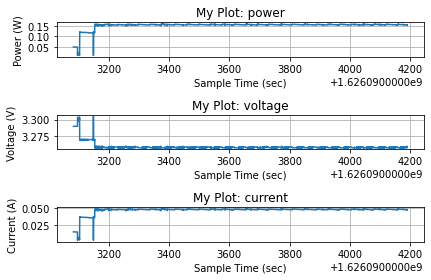

In [35]:
%matplotlib inline

import oml_plot_tools.consum
filename = "output/%s/consumption/%s.oml" % (job_id, iotlab_roles["border-router"][0].alias)
filename = filename.replace('-', "_", 1) # fix the name m3-10 to m3_10
data = oml_plot_tools.consum.oml_load(filename)
oml_plot_tools.consum.consumption_plot(data, "My Plot:", 'all')

### Cleanup

Stop tunslip on frontend

In [36]:
result = run_command('pgrep -u "$(whoami)" tunslip6 | xargs kill', roles=frontend_roles)

None

PLAY [all] *********************************************************************

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on strasbourg]
changed: [strasbourg]


Destroy provider, free resources in testbed

In [37]:
iotlab_provider.destroy()

[    INFO] : Stopping experiment id (271937)
[    INFO] : Deleting monitoring profile: energy


## RPL + CoAP + TSCH

## RPL + CoAP + NullRDC

In [7]:
iotlab_dict = {
    "job_name": "hackathon",
    "walltime": "03:00",       # duration of the experiment: e.g. 1 hour
    "resources":
    {"machines": [
        {
            "roles": ["coap-server"],      # user-defined role for these nodes: CoAP servers
            "archi": "m3:at86rf231",       # architecture of the nodes: M3
            "site": "strasbourg",
            "number": 3,
            "image": "firmware/nullrdc/er-example-server.iotlab-m3",     # initial image to be installed on the nodes
            "profile": "energy",           # monitoring profile, defined below
        },
        {
            "roles": ["border-router"],   # user-defined string, 1 border-router in our example
            "archi": "m3:at86rf231",
            "site": "strasbourg",
            "number": 1,
            "image": "firmware/nullrdc/border-router.iotlab-m3",
            "profile": "energy",
        },
    ]},
    "monitoring": {
        "profiles": [{
            "name": "energy",           # More details: https://www.iot-lab.info/legacy/tutorials/monitoring-consumption-m3/index.html
            "archi": "m3",
            "consumption": {
                "current": True,
                "power": True,
                "voltage": True,
                "period": 8244,         # interval between measurements in us
                "average": 4,
            },
        }]
    }
}

# creating the object for our reservation
# the nodes aren't avaible until you call init() on these objects
iotlab_conf = IotlabConf.from_dictionary(iotlab_dict)
iotlab_provider = Iotlab(iotlab_conf)